# Cluster data using a mixture of Gaussians generative model.

Marcus Frean

Expects to read a datafile consisting of a matrix in which each row is
a training item.

In [1]:
%matplotlib inline
import sys, math
from pylab import *
import numpy as np
import numpy.random as rng
import numpy.linalg as linalg
from matplotlib.patches import Ellipse
matplotlib.rcParams['figure.figsize'] = [12,12]
MAX_NUM_COMPONENTS = 100
randColor = rng.random((MAX_NUM_COMPONENTS,3))
randColor = randColor/randColor.sum(1).reshape(MAX_NUM_COMPONENTS,1)

In [2]:
def  save_figure(out_image_name, mix_coeff, means, variances, data):
    NUM_COMPONENTS = len(mix_coeff)
    f1 = figure()
    #title('%d Gaussians' % (NUM_COMPONENTS))
    for k in range(NUM_COMPONENTS):
        transparency = mix_coeff[k]
        ellipsePlot=plotEllipse(means[:,k],variances[:,:,k],'blue',randColor[k],transparency)
        
    scatter(data[:,0], data[:,1], marker='o',s=5,linewidths=None,alpha=0.5)
    axis('equal')  # uncomment to give the 2 axes the same scale
    axis([min(data[:,0]), max(data[:,0]), min(data[:,1]), max(data[:,1])])
    draw()
    savefig(out_image_name)
    #print '\n  saved image ',out_image_name
    return

In [3]:
def plotEllipse(pos,P,edge,face,transparency):
    U, s , Vh = svd(P)
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]),
                          height=2.0*math.sqrt(s[1]), angle=orient,
                          facecolor=face,edgecolor=None,alpha=np.power(transparency,0.5), 
                          zorder=10)
    ax = gca()
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [4]:
def GaussianDensity(d,mu,v):
    """
    returns the prob of data d (matrix with items as rows), under the
    Gaussian given by mu (vector) and var (matrix)
    """
    NUM_ITEMS,NUM_DIMS = d.shape
    normalisation = pow(2*math.pi,len(mu)/2) * math.sqrt(linalg.det(v))
    xx = d-mu  # xx is the deviations of the data from mu
    # nb: xx  will be matrix with shape [NUM_ITEMS,NUM_DIMS]
    yy = np.dot(linalg.inv(v), xx.transpose()).transpose()
    s = np.zeros(NUM_ITEMS, float)
    for d in range(NUM_DIMS):
        s = s + xx[:,d] * yy[:,d]    # no doubt there's a more numpoid way but anyways.
    p = np.exp(-0.5*s)/normalisation 
    if any(p) == 0.0:
        sys.exit('a probability went to zero')
    return p

In [5]:
def calc_logL_one_component(datas, mu, var):
    logL = np.sum( np.log( GaussianDensity(datas, mu, var)))
    return logL

In [6]:
def do_one_step_EM(mix_coeff, means, variances, data, FORCE_DIAGONAL_COV):
    start_mix_coeff, start_means, start_variances =  mix_coeff, means, variances

    MIN_VARIANCE = 0.2    # attempts to prevent variance dropping to zero...
    NUM_DATA_DIM,NUM_COMPONENTS = means.shape
    NUM_DATA_ITEMS = len(data)
    r = 1.0* np.ones((NUM_DATA_ITEMS,NUM_COMPONENTS))     # start off all the same
    # E step___________________________________________________
    # Evaluate the responsibilities using the current parameter values.
    for k in range(NUM_COMPONENTS):
        if all(np.ravel(variances[:,:,k]) == 0.0):
            print ('******** oops: all of the variances for component %d are zero!' % (k))
            print ( variances)
            sys.exit()
        r[:,k] = mix_coeff[k] * GaussianDensity(data, means[:,k], variances[:,:,k])
    r_sum = r.sum(1)
    if any(r_sum <= 0.0):
        print ( 'Ouch: an entry in r_sum was not positive, but they all should be.' )
        print ( 'Whole r was ' )
        for ind,rr in enumerate(r):
            print ( ind, '   :   ', rr)
        print ( 'r_sum is ', r_sum)
        print ( '\nWhole means was') 
        for ind,m in enumerate(means):
            print (ind, '   :   ',m)
        sys.exit()
    # gamma is 'responsibility', or r normalised, as per Bishop
    gamma = (r.transpose() / r_sum).transpose()
    gamma_sums = gamma.sum(0) #ie. summed over the 0-th dimension

    # M step___________________________________________________
    for k in range(NUM_COMPONENTS):
        g = (data.transpose() * gamma[:,k]).sum(1)
        # update the means
        means[:,k] = g / gamma_sums[k]
        # update the mixing coefficient
        mix_coeff[k] = gamma_sums[k]/sum(gamma_sums)
        # update the (co)variances
        x = data - means[:,k]
        V = 1.0*np.eye(NUM_DATA_DIM)
        for i in range(NUM_DATA_DIM):
            for j in range(NUM_DATA_DIM):
                V[i,j] = sum(x[:,i]*x[:,j] * gamma[:,k])
        if FORCE_DIAGONAL_COV:
            for i in range(NUM_DATA_DIM):
                for j in range(NUM_DATA_DIM):
                    if (i != j): V[i,j]=0.0
        # Try to pevent variances collapsing to zero, along the diagonal...
        for i in range(NUM_DATA_DIM):
            V[i,i] = max(V[i,i], MIN_VARIANCE)
        variances[:,:,k] = V / gamma_sums[k]
    logL = np.log(r_sum).sum() # that was easy!
    return [mix_coeff, means, variances, logL]

In [7]:
def run_EM_MoG(NUM_RESTARTS,data,NUM_COMPONENTS,NUM_EM_ITERATIONS=10,FORCE_DIAGONAL_COV=False, out_stem=''):
    (NUM_DATA_ITEMS,NUM_DATA_DIM) = data.shape
    if NUM_COMPONENTS > MAX_NUM_COMPONENTS:
        sys.exit('you need to increase MAX_NUM_COMPONENTS')

    best_logL = -1000000.0
    for restart in range(NUM_RESTARTS):
        # Set initial guestimates for means, variances, and mixture coefficients
        means = np.zeros((NUM_DATA_DIM,NUM_COMPONENTS),float)   # centers start off
        used = []
        for k in range(NUM_COMPONENTS):           
            n = rng.randint(NUM_DATA_ITEMS) # on randomly chosen data points
            while (n in used):
                n = rng.randint(NUM_DATA_ITEMS) # on randomly chosen data points
            used.append(n)
            means[:,k] = data[n,:]

        variances = 1.0*np.ones((NUM_DATA_DIM,NUM_DATA_DIM,NUM_COMPONENTS),float)     # initial variances
        for k in range(NUM_COMPONENTS):                     # start off spherical
            variances[:,:,k] = np.eye(NUM_DATA_DIM)          
        mix_coeff = np.ones((NUM_COMPONENTS),float)/NUM_COMPONENTS          # mixing coefficients

        prev_logL = -100000000000.0
        for iteration in range(NUM_EM_ITERATIONS+1):
            if len(out_stem)>0:
                out_image_name = '%s_EM_itn%d.png' %(out_stem,iteration)
                if (iteration % 20 == 0) :
                    save_figure(out_image_name, mix_coeff, means, variances, data)

            #for k in range(NUM_COMPONENTS):
            #    print 'component ',k,'   logL ',calc_logL_one_component(data, means[:,k], variances[:,:,k])

            [mix_coeff, means, variances, logL] = do_one_step_EM(mix_coeff, means, variances,data,FORCE_DIAGONAL_COV)
            #print '\t after iteration %3d updates, logL %12.6f' % (iteration,logL)
            if (logL - prev_logL < -0.01):
                print ("------------------------The log likelihood just went DOWN!---------")
                print ('means: ', means)
                print ('variances: ')
                for k in range(NUM_COMPONENTS):
                    print (np.diag(variances[:,:,k]))
                print ( 'coefficients: ', mix_coeff)
                sys.exit(0)
            prev_logL = logL
        print ( '\t FINAL model in restart #%d: logL %12.6f' % (restart,logL))
        if (logL > best_logL):
            best_logL = logL
            best_model = [mix_coeff, means, variances, logL]
    # END OF THE EM LOOP____________________________________________
    print ('Best model found in %d restarts has logL=%12.6f' % (NUM_RESTARTS,best_logL))
    return best_model

### and finally...



In [8]:
NUM_COMPONENTS = 20
NUM_EM_ITERATIONS = 50
infile = 'test-MoG.csv'

# I include this in case anyone wants to run as a command line program instead.
if False:   #__name__ == '__main__':
    if len(sys.argv) == 4:
        NUM_COMPONENTS = int(sys.argv[1]) # number of components
        NUM_EM_ITERATIONS = int(sys.argv[2])
        infile = str(sys.argv[3])
        print ('We are assuming %d classes' % (NUM_COMPONENTS))
    else:
        sys.exit('usage: python EMmix.py numClasses  NUM_EM_ITERATIONS  NUM_RESTARTS  infile')

out_stem = infile.split('.')[0]

	 FINAL model in restart #0: logL -29833.565034
Best model found in 1 restarts has logL=-29833.565034


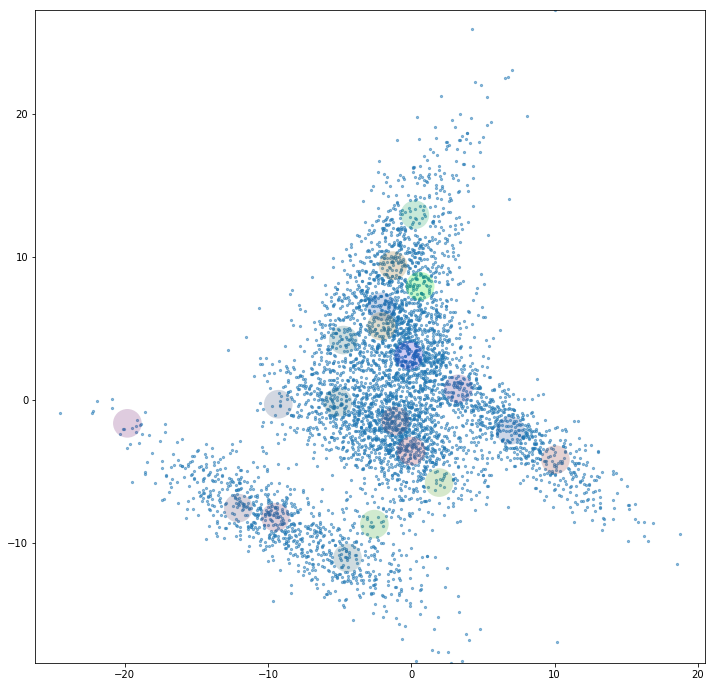

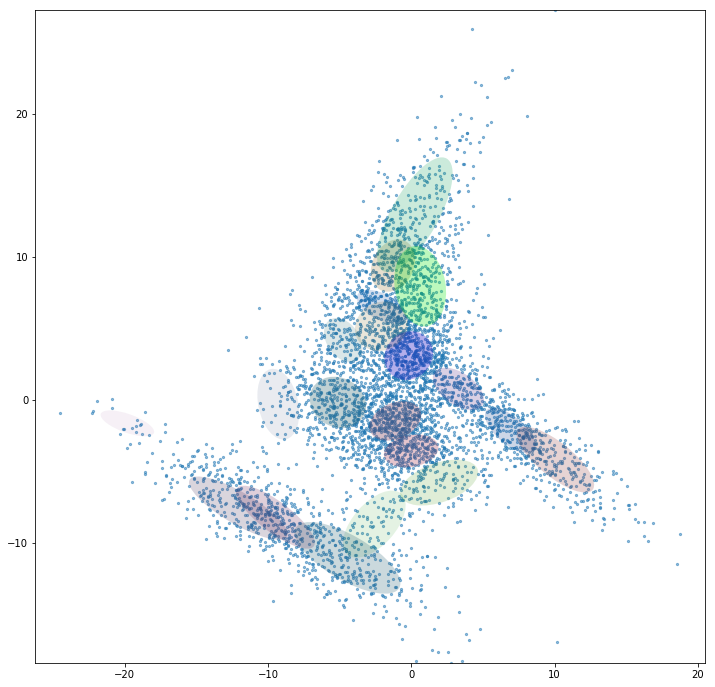

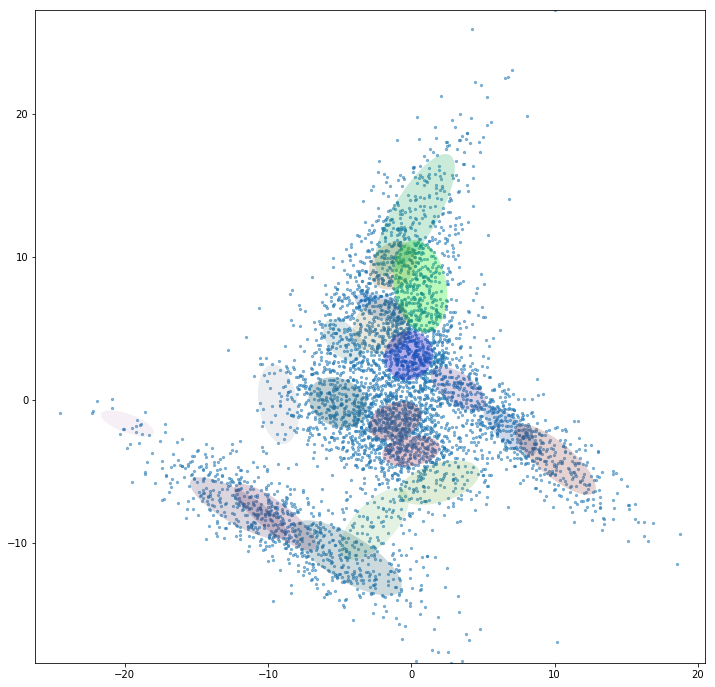

In [9]:
NUM_RESTARTS = 1 # set higher if you want to avoid local optima.

data = np.genfromtxt(infile, float) #, unpack=True)
NUM_DATA_ITEMS,NUM_DATA_DIM = data.shape
[mix_coeff, means, variances, logL] = run_EM_MoG(NUM_RESTARTS,data,NUM_COMPONENTS,NUM_EM_ITERATIONS,False,out_stem)


  saved image  test-MoG_faked.png


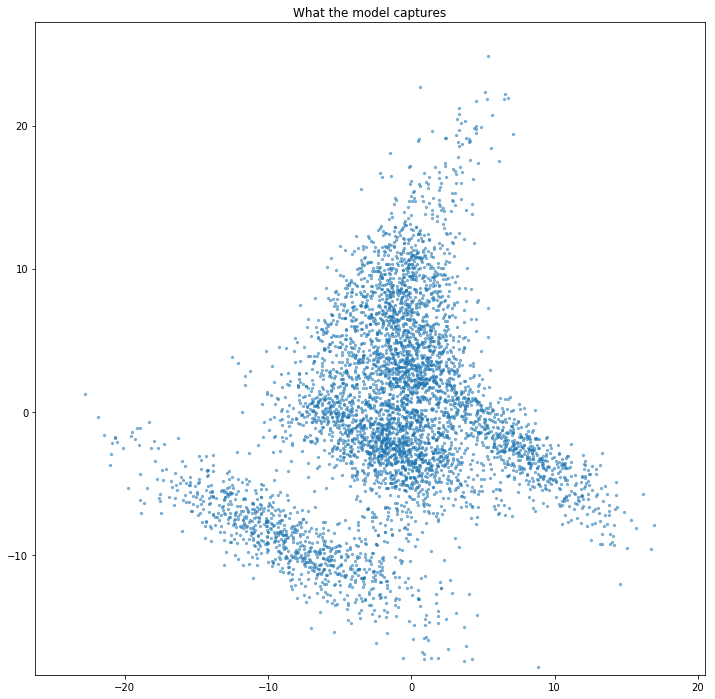

In [10]:
# for fun, we can now show samples from this model, to cf. original data.
f2 = figure()
title('What the model captures')
X = zeros((NUM_DATA_ITEMS,NUM_DATA_DIM))
for i in range(NUM_DATA_ITEMS):
    j = sum(rng.random() > cumsum(mix_coeff))
    X[i,:] = np.array([rng.multivariate_normal(means[:,j],variances[:,:,j],1)])
scatter(X[:,0], X[:,1], marker='o',s=5,linewidths=None,alpha=0.5)
axis('equal')
axis([min(data[:,0]), max(data[:,0]), min(data[:,1]), max(data[:,1])])
draw()
out_imagename = out_stem+'_faked.png'
savefig(out_imagename)
print ( '\n  saved image ',out_imagename )